In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# 加载数据
data = pd.read_csv('/Users/lyndseyxia/Desktop/NYU/capstone/fall/SP600_AdjClose_Volume_Return.csv')
data['Date'] = pd.to_datetime(data['Date'])  # 确保日期格式正确
data.set_index('Date', inplace=True)

# 预处理数据，假设 'Adj Close' 是股票的收盘价
data['Daily Return'] = data['Adj Close'].pct_change()
data['Rolling Volatility'] = data['Daily Return'].rolling(window=20).std()
delta = data['Adj Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# 清除缺失值
data.dropna(inplace=True)

# 特征选择
features = data[['Volume', 'Daily Return', 'Rolling Volatility', 'RSI']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# 应用 PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data = principal_components, columns=['PC1', 'PC2'])

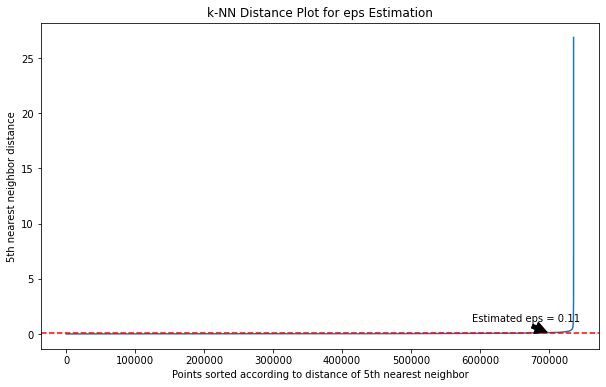

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# 假设 scaled_features 是已经标准化的特征数据
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)

# 排序距离
sorted_distances = np.sort(distances, axis=0)[:, 1]  # 选择第二小的距离
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.title("k-NN Distance Plot for eps Estimation")
plt.xlabel("Points sorted according to distance of 5th nearest neighbor")
plt.ylabel("5th nearest neighbor distance")

# 添加水平线来估计 eps
eps_estimate = sorted_distances[int(0.95 * len(sorted_distances))]  # 假设拐点在95%的位置
plt.axhline(y=eps_estimate, color='r', linestyle='--')
plt.annotate(f'Estimated eps = {eps_estimate:.2f}', xy=(0.95 * len(sorted_distances), eps_estimate), xytext=(0.8 * len(sorted_distances), eps_estimate + 1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

plt.show()


In [4]:
# 分批应用 DBSCAN
def batch_dbscan(data, batch_size=1000, eps=0.8, min_samples=10):
    n_samples = data.shape[0]
    labels = np.full(n_samples, -1, dtype=int)  # 初始化所有点为噪声
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch = data[start:end]
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        batch_labels = dbscan.fit_predict(batch)
        
        # 更新标签，需要处理边界点的标签
        labels[start:end] = batch_labels
    
    return labels

# 执行分批 DBSCAN
labels = batch_dbscan(pca_df.values)

# 将标签添加到原始数据框
data['Cluster'] = labels

# 分析和可视化结果
print(data['Cluster'].value_counts())

 0    723779
-1      7252
 1      3288
 2      1226
Name: Cluster, dtype: int64


In [5]:
# 初始参数
eps_values = [0.5, 0.4, 0.3, 0.2, 0.1]  # 逐步减小eps
min_samples_values = [10, 8, 5]  # 逐步减小min_samples

# 测试不同的参数组合
for eps in eps_values:
    for min_samples in min_samples_values:
        labels = batch_dbscan(pca_df.values, eps=eps, min_samples=min_samples)
        data['Cluster'] = labels
        anomaly_count = (data['Cluster'] == -1).sum()
        print(f"EPS: {eps}, Min Samples: {min_samples}, Anomalies: {anomaly_count}")


EPS: 0.5, Min Samples: 10, Anomalies: 14919
EPS: 0.5, Min Samples: 8, Anomalies: 13119
EPS: 0.5, Min Samples: 5, Anomalies: 9755
EPS: 0.4, Min Samples: 10, Anomalies: 21284
EPS: 0.4, Min Samples: 8, Anomalies: 18325
EPS: 0.4, Min Samples: 5, Anomalies: 13430
EPS: 0.3, Min Samples: 10, Anomalies: 33471
EPS: 0.3, Min Samples: 8, Anomalies: 28639
EPS: 0.3, Min Samples: 5, Anomalies: 20548
EPS: 0.2, Min Samples: 10, Anomalies: 61099
EPS: 0.2, Min Samples: 8, Anomalies: 52256
EPS: 0.2, Min Samples: 5, Anomalies: 37317
EPS: 0.1, Min Samples: 10, Anomalies: 162242
EPS: 0.1, Min Samples: 8, Anomalies: 138018
EPS: 0.1, Min Samples: 5, Anomalies: 96975


In [6]:
data

,Adj Close,Volume,Ticker,Return,Daily Return,Rolling Volatility,RSI,Cluster
Date,,,,,,,,
2019-10-28,151.906799,978800,AAP,0.005134,0.005134,0.013407,81.166427,0
2019-10-29,150.026291,657500,AAP,-0.012379,-0.012379,0.013432,73.267822,0
2019-10-30,149.679413,721600,AAP,-0.002312,-0.002312,0.012082,69.851578,0
2019-10-31,148.319275,826600,AAP,-0.009087,-0.009087,0.011429,60.272637,0
2019-11-01,150.455353,677800,AAP,0.014402,0.014402,0.011821,68.582663,0
...,...,...,...,...,...,...,...,...
2024-09-23,34.169998,1511400,ZWS,-0.019231,-0.019231,0.024073,66.179743,0
2024-09-24,34.669998,988700,ZWS,0.014633,0.014633,0.024107,72.945177,0
2024-09-25,34.700001,1020700,ZWS,0.000865,0.000865,0.024079,75.087693,0


In [7]:
# 筛选出标记为异常的数据点
anomalies = data[data['Cluster'] == -1].copy()

# 确保日期列为DataFrame的一部分以便导出
anomalies.reset_index(inplace=True)

# 选择导出的列
anomalies_to_export = anomalies[['Date', 'Ticker', 'Adj Close', 'Volume', 'Daily Return', 'Rolling Volatility', 'RSI']]

# 将CSV文件保存到临时目录或其他已知的可写目录
anomalies_to_export.to_csv('/Users/lyndseyxia/Desktop/NYU/capstone/fall/anomalies_dbscan_pca.csv', index=False)

In [8]:
# 加载CSV文件
anomalies_df = pd.read_csv('/Users/lyndseyxia/Desktop/NYU/capstone/fall/anomalies_dbscan_pca.csv')

# 打印行数和列数
print("Number of rows:", anomalies_df.shape[0])
print("Number of columns:", anomalies_df.shape[1])

# 打印列名以查看具体有哪些列
print("Columns:", anomalies_df.columns.tolist())


Number of rows: 96975
Number of columns: 7
Columns: ['Date', 'Ticker', 'Adj Close', 'Volume', 'Daily Return', 'Rolling Volatility', 'RSI']


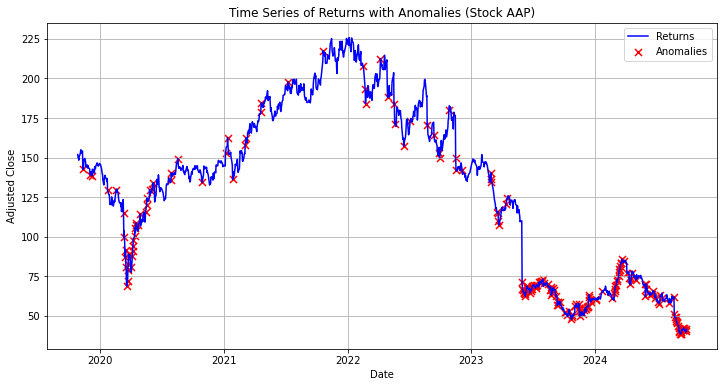

In [9]:
# 可视化特定股票
stock_index = 'AAP'  # 选择一个股票标识符，这里以苹果公司为例
selected_stock = data[data['Ticker'] == stock_index]

# 绘制时间序列图，展示正常点和异常点
plt.figure(figsize=(12, 6))
plt.plot(selected_stock.index, selected_stock['Adj Close'], label='Returns', color='blue')
anomalies = selected_stock[selected_stock['Cluster'] == -1]
plt.scatter(anomalies.index, anomalies['Adj Close'], color='red', label='Anomalies', marker='x', s=50)

# 设置图表标题和标签
plt.title(f'Time Series of Returns with Anomalies (Stock {stock_index})')
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()


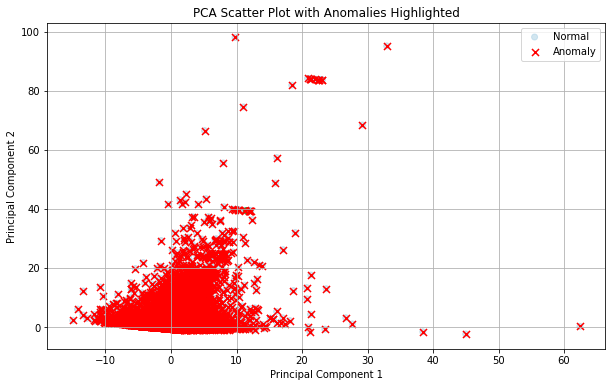

In [12]:
# 使用PCA结果绘制散点图，区分异常点
plt.figure(figsize=(10, 6))
plt.scatter(pca_df.iloc[:, 0], pca_df.iloc[:, 1], c=labels, cmap='Paired', label='Normal', alpha=0.5)
plt.scatter(pca_df.iloc[labels == -1, 0], pca_df.iloc[labels == -1, 1], color='red', label='Anomaly', marker='x', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot with Anomalies Highlighted')
plt.legend()
plt.grid(True)
plt.show()


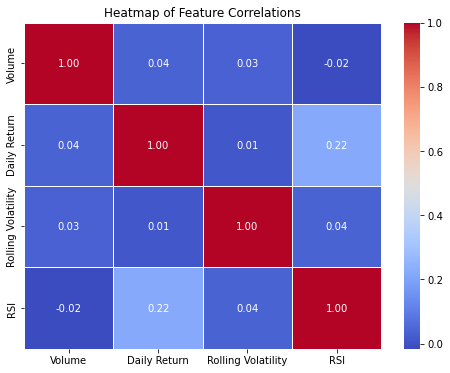

In [13]:
# 计算特征之间的相关性矩阵
correlation_matrix = features.corr()

# 绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap of Feature Correlations')
plt.show()
